In [1]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prev

In [2]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@Noelia_Carrion9_tweets.csv')

In [3]:
tweets_user.head()

,id,created_at,text
0,1156508893893275648,2019-07-31 10:16:21,RT @voz_populi: Podemos e IU denuncian a ocho ...
1,1156508767934136321,2019-07-31 10:15:51,RT @MujeresRtve: Nuestro pesar por la muerte d...
2,1156508688506589184,2019-07-31 10:15:32,RT @elespanolcom: #Investigación | Científicos...
3,1156508626317656067,2019-07-31 10:15:18,RT @TheObjective_es: En la primera de las cuat...
4,1156508475406635008,2019-07-31 10:14:42,"RT @eldiarioes: ""Afilando los cuchillos"": iLe ..."


In [4]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [5]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [6]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [7]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [8]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [9]:
tweets_user['date'] = tweets_user['created_at']

In [10]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [11]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [12]:
nlp = es_core_news_sm.load()

In [13]:
nlp = spacy.load('es', parser=True)

In [14]:
nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt"}

In [15]:
def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [16]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [19]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

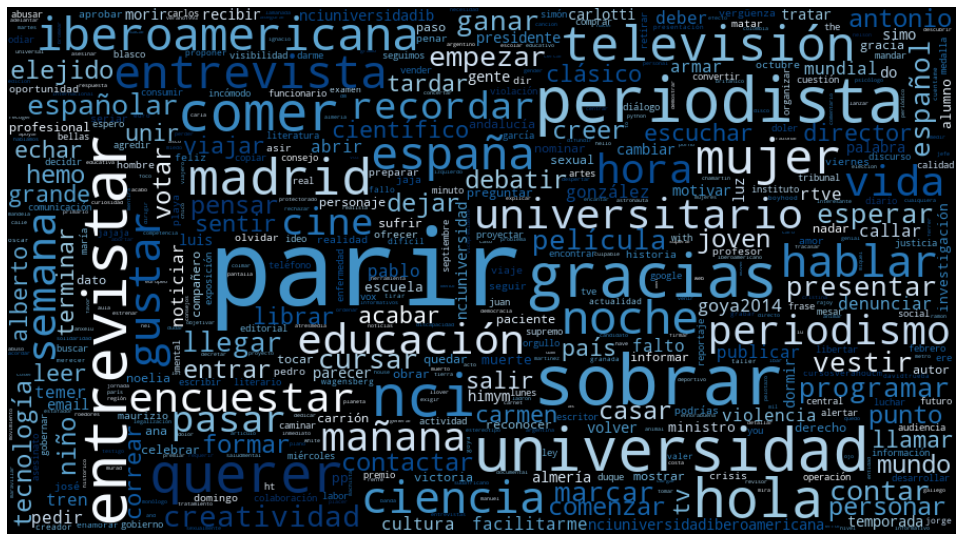

In [20]:
all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:

tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)

print(tfidf_matrix.shape)

CPU times: user 5.73 s, sys: 12.3 ms, total: 5.74 s
Wall time: 5.74 s
(641, 309)


In [22]:
terms = tfidf_vectorizer.get_feature_names()

In [23]:
array_matrix = tfidf_matrix.toarray()

In [24]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
operación,0.603894
denunciar,0.563610
ministro,0.563610
noche,0.000000
olvidar,0.000000


In [25]:
vocab = tfidf_vectorizer.vocabulary_

In [26]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[-4.44089210e-16,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

In [27]:
umap = UMAP(n_components=2, n_neighbors=5)
embedding = umap.fit_transform(dist)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/miniconda3/envs/py366/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/miniconda3/envs/py366/lib/python3.6/site-packages/numba/compiler.py

In [28]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [29]:
umap_df.head()

,emb_1,emb_2
0,17.656761,-12.534234
1,17.271494,-12.691813
2,17.103878,-9.931827
3,17.632088,-12.545795
4,18.887489,-10.756803


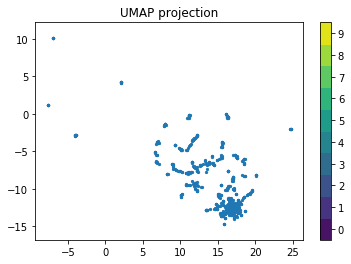

In [30]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

hdbscan = HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

hdbscan.labels_.max()

labels = hdbscan.labels_

fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))

In [96]:
num_clusters = 8

km = KMeans(n_clusters=num_clusters)

%time clustering = km.fit_predict(embedding)

clusters = km.labels_.tolist()

CPU times: user 60.8 ms, sys: 1.62 ms, total: 62.5 ms
Wall time: 61.1 ms


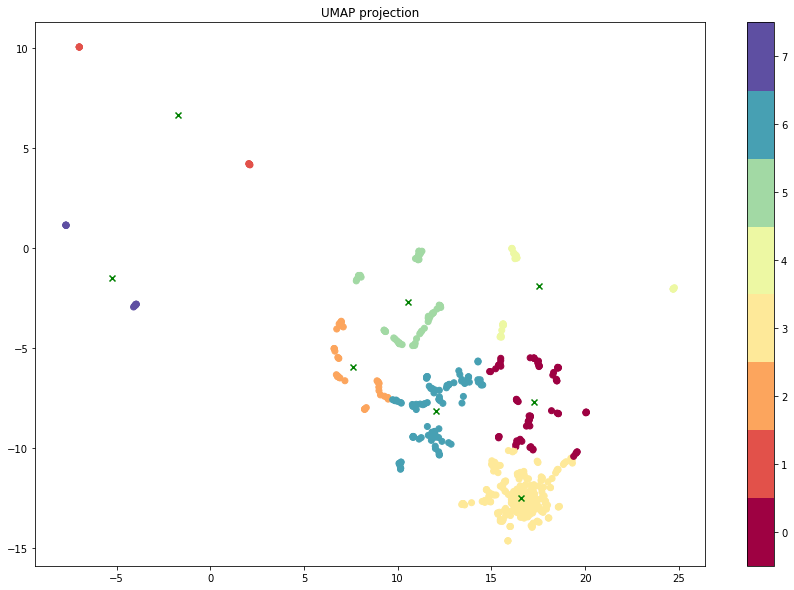

In [99]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
centers = np.array(km.cluster_centers_)

plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

In [98]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

Silhouette Coefficient: 0.522


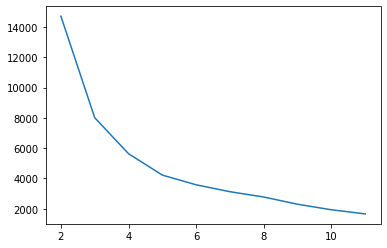

In [100]:
inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

In [101]:
tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet', 'words', "cluster"])

In [102]:
frame[frame['cluster']==0].head()

,tweet,words,cluster
0,RT @elespanolcom: #Investigación | Científicos...,"[investigación, científicos, españolar, creer,...",0
0,"RT @EdPeriodismo: Ya está aquí, proyecto final...","[proyectar, promoción, escuela, periodismo, ua...",0
0,RT @ramonlobo: ¿Seremos capaces los periodista...,"[seremos, capaz, periodista, limpiar, cloaca, ...",0
0,RT @fnelida: A los periodistas de Efe que fuer...,"[periodista, efe, detenido, cincar, funcionari...",0
0,RT @el_pais: Ni todos los jóvenes tienen aspir...,"[joven, aspiración, académico, requerir, titul...",0


In [103]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,abrir,abusar,acabar,actividad,actualidad,agredir,alberto,almería,alumno,amor,...,viernes,violación,violencia,visibilidad,visitar,volver,votar,vox,wagensberg,you
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.409703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [114]:
top_words_cluster = get_df_from_cluster(7).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(20)

encuestar                       5.247531
universitario                   5.168161
hola                            4.841096
nciuniversidadiberoamericana    4.489609
parir                           3.041238
gracia                          3.001754
programar                       0.680433
semana                          0.653649
you                             0.000000
encontrar                       0.000000
enfermedad                      0.000000
entrar                          0.000000
entrevistar                     0.000000
escribir                        0.000000
erar                            0.000000
empezar                         0.000000
escritor                        0.000000
escuchar                        0.000000
escuela                         0.000000
españa                          0.000000
dtype: float64